<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Imports" data-toc-modified-id="Data-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Imports</a></span></li><li><span><a href="#Data-Examination" data-toc-modified-id="Data-Examination-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Examination</a></span><ul class="toc-item"><li><span><a href="#Photos" data-toc-modified-id="Photos-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Photos</a></span></li><li><span><a href="#Label-distribution" data-toc-modified-id="Label-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Label distribution</a></span></li></ul></li><li><span><a href="#Network-implementation" data-toc-modified-id="Network-implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Network implementation</a></span></li></ul></div>

# Bird Classifier

Built using the Kaggle sourced <a href=https://www.kaggle.com/datasets/gpiosenka/100-bird-species>dataset</a> of 525 bird species.

## Data Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models

from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [3]:
batch_size = 16

In [4]:
data_dir = '/media/metal_undivided/DATA/Datasets/Kaggle_525_species/'

train_dataset = datasets.ImageFolder(data_dir + 'train/', transform=transform)
val_dataset = datasets.ImageFolder(data_dir + 'valid/', transform=transform)
test_dataset = datasets.ImageFolder(data_dir + 'test/', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
#next(iter(train_dataloader))[0]

The data is successfully imported, let's examine it.

## Data Examination

### Photos

In [6]:
pixels, labels = next(iter(train_dataloader))

Let's also get the label-species pairs for visualisation.

In [7]:
species = train_dataset.find_classes(data_dir + 'train/')
species = {label:name for name, label in species[1].items()}

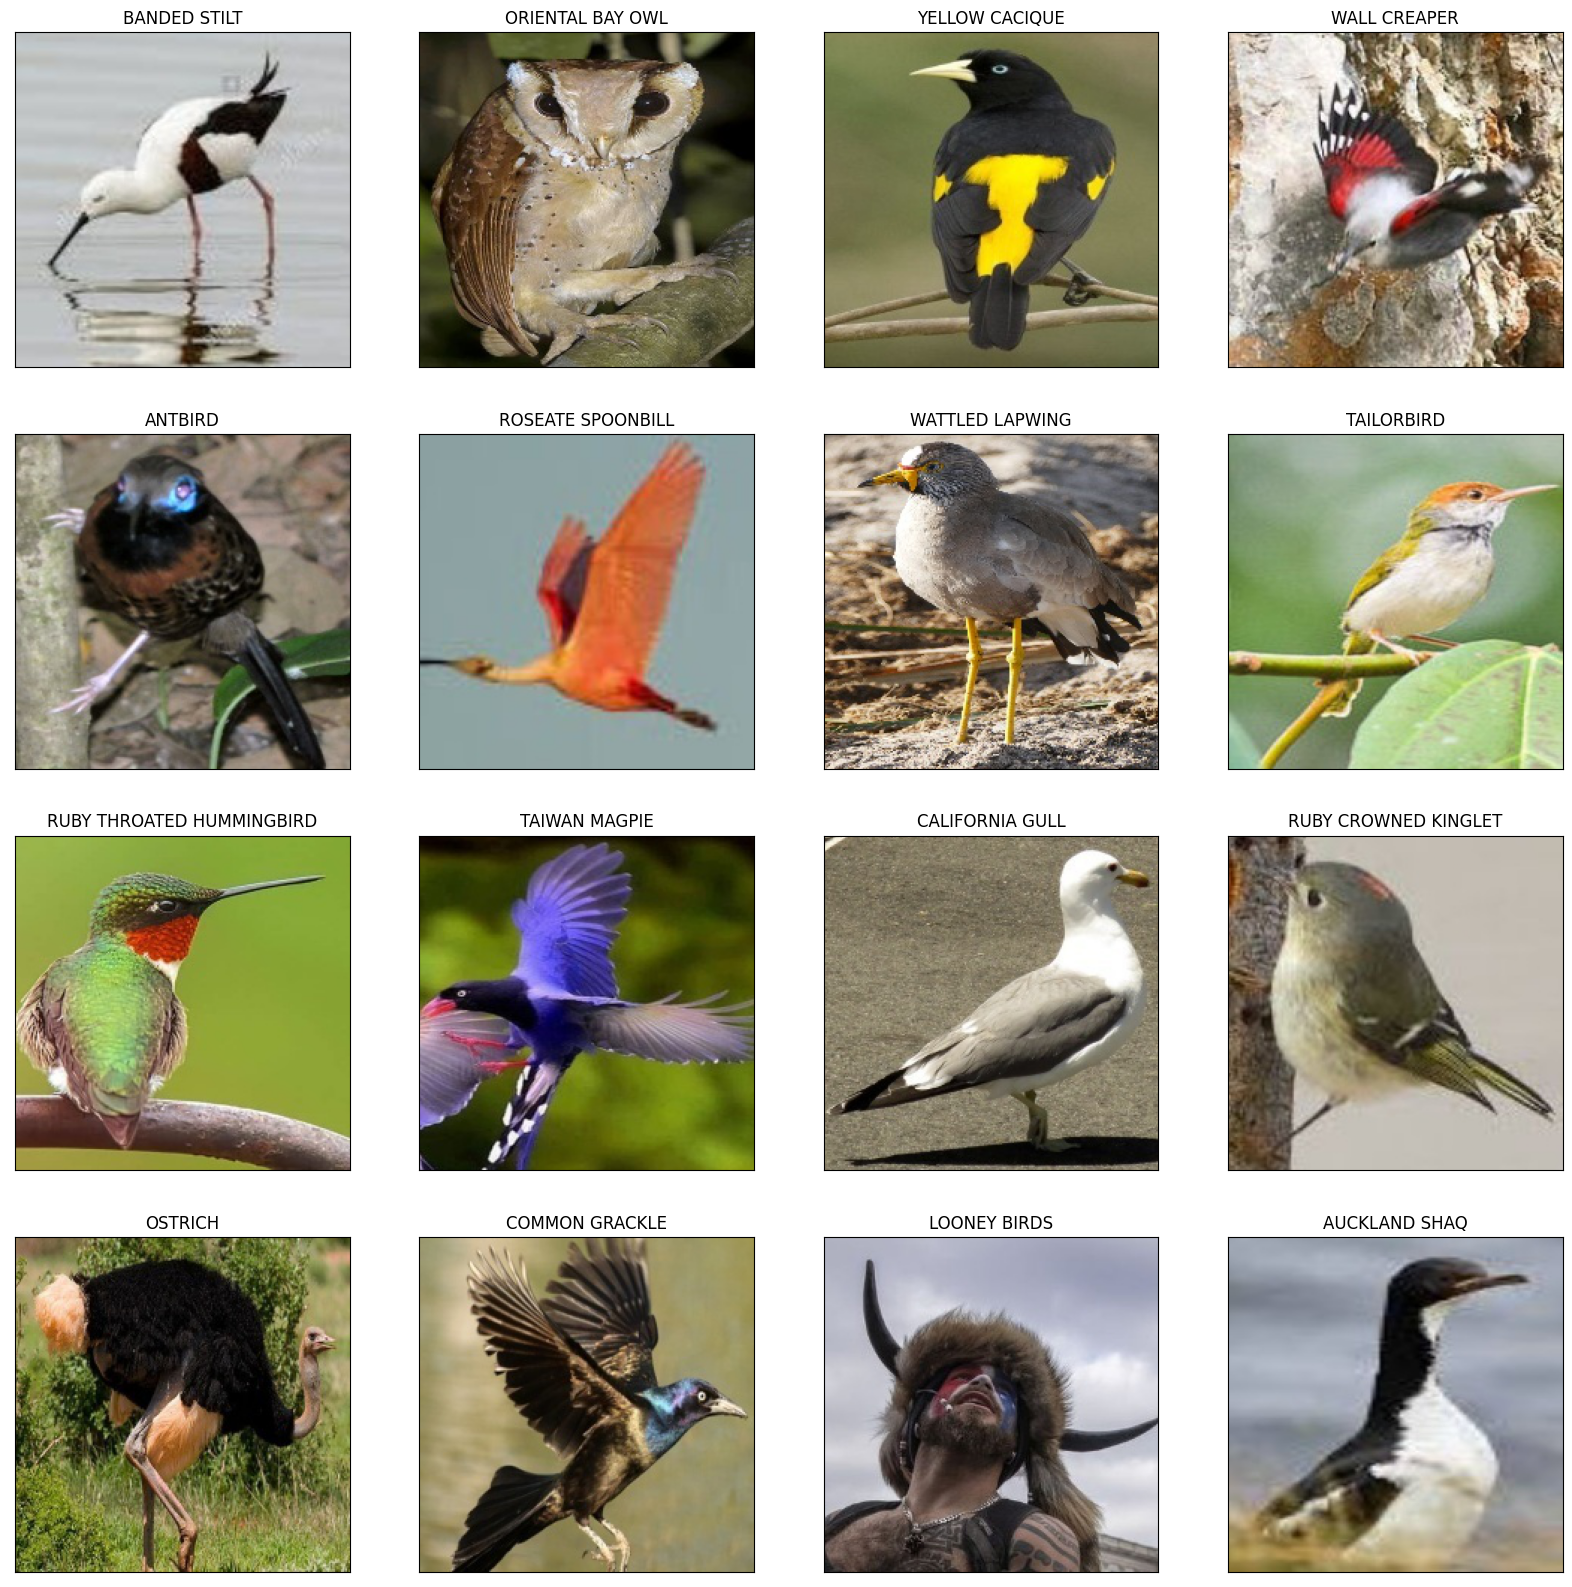

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i in range(16):
    axobject = axs[i // 4][i % 4]
    
    axobject.imshow(pixels[i].permute(1, 2, 0))
    axobject.set_title(species[labels.numpy()[i]])
    axobject.get_xaxis().set_visible(False)
    axobject.get_yaxis().set_visible(False)

Looks good, both the names and the images.

Before implementing the network, let's see how many photos of each bird we have.

### Label distribution

Since iterating over all the classes is fairly time consuming, this section is normally omitted and counts precalculated here are used instead.

```python
species_count = torch.zeros(525)
species_count.requires_grad = False

for counter, batch in enumerate(tqdm(train_dataloader)):
    _, labels = batch
    species_count += nn.functional.one_hot(labels, num_classes=525).sum(axis=0)    
    
```

```python
torch.save(species_count, 'species_count')
```

Loading precalculated counts

In [9]:
species_count = torch.load('species_count')

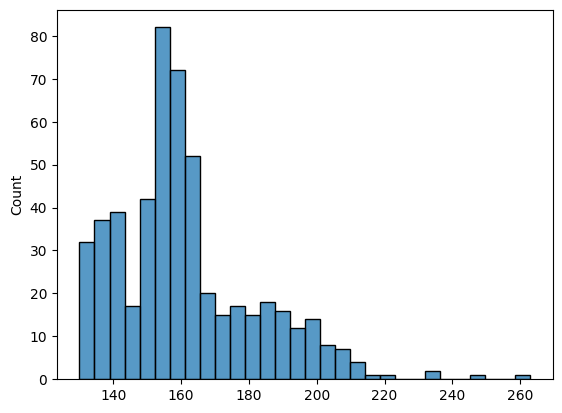

In [10]:
sns.histplot(species_count.numpy(), bins=30);

Most of the classes are fairly equally represented, save for a few outliers.

In order to improve learning, we'll use the inverse of these counts as class weights.

## Network implementation

For this task I'll be implementing a ResNet network.

In [25]:
class ResNet(nn.Module):
    
    def __init__(self, n_labels):
        super(ResNet, self).__init__()
        
        self.base = nn.Conv2d(3, 64, (7, 7), stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        
        self.block1 = self.ResNetLayer(BottleneckBlock, 64, 64, 256, 3)
        self.block2 = self.ResNetLayer(BottleneckBlock, 256, 128, 512, 4)
        self.block3 = self.ResNetLayer(BottleneckBlock, 512, 256, 1024, 6)
        self.block4 = self.ResNetLayer(BottleneckBlock, 1024, 512, 2048, 3)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(2048, n_labels, bias=True)
        
    
    def forward(self, x):
        
        x = self.base(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        
        x = self.block1(x)
        x = self.block2(x)
        #print(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        #x = nn.Softmax(dim=1)(x)
        
        return x
    
    
    def ResNetLayer(self, block, input_channels, interm_channels, output_channels, repetitions, first_layer=False):
        
        layer = nn.Sequential()
        
        layer.append(block(input_channels, interm_channels, output_channels, stride=2, residual_downsample=True))
        
        for repetition in range(repetitions - 1):
            layer.append(block(output_channels, interm_channels,output_channels))
        
        return layer

In [24]:
class BottleneckBlock(nn.Module):
    
    def __init__(self, input_channels, interm_channels, output_channels, stride=1, residual_downsample=False):
        super(BottleneckBlock, self).__init__()
        self.input_channels = input_channels
        self.interm_channels = interm_channels
        self.output_channels = output_channels
        self.residual_downsample = residual_downsample
        
        self.layer1 = nn.Conv2d(input_channels, interm_channels, (1, 1), stride=stride)
        self.bn1 = nn.BatchNorm2d(interm_channels)
        self.layer2 = nn.Conv2d(interm_channels, interm_channels, (3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(interm_channels)
        self.layer3 = nn.Conv2d(interm_channels, output_channels, (1, 1), stride=1)
        self.bn3 = nn.BatchNorm2d(output_channels)
        if residual_downsample:
            self.residual = nn.Conv2d(input_channels, output_channels, (1, 1), stride=stride)
            self.res_bn = nn.BatchNorm2d(output_channels)
        
        
    def forward(self, x):
        
        x_init = x
        x = self.layer1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = self.bn3(x)
        
        if self.residual_downsample:
            x_init = self.residual(x_init)
            x_init = self.res_bn(x_init)
            x += x_init
        else:
            x+= x_init
            
        x = nn.ReLU()(x)
        
        return x
    

In [13]:
def fit_batch(model, features, target, optimizer, loss_fn):
    
    optimizer.zero_grad(set_to_none=True)
    
    predictions = model(features)
    
    loss = loss_fn(predictions, target)
    loss.backward()
    
    optimizer.step()
    
    return loss

In [14]:
torch.cuda.is_available()

False

In [23]:
#models.resnet50()

In [34]:
model = ResNet(n_labels=525)
#model = models.resnet50()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())

loss_fn = nn.CrossEntropyLoss()#weight=(species_count.mean() / species_count) ** 2)

In [28]:
#model

In [35]:
model.train(True)

for epoch in range(5):

    ## training
    total_loss = 0
    for counter, batch in enumerate(tqdm(train_dataloader)):

        features, target = batch

        total_loss += fit_batch(model, features, target, optimizer, loss_fn).item() 

        if counter % 100 == 99:
            last_loss = total_loss / len(batch) / 100
            print('Batch {1} loss: {0:.8f}'.format(last_loss, counter + 1))
            total_loss = 0
            
    ## validation
    with torch.no_grad():
        correct_labels = 0
        
        for counter, batch in enumerate(val_dataloader):
            
            pixels, labels = batch
            
            ## all predictions
            predictions = torch.max(model(pixels), dim=1)[1]
            ## number of correct predictions
            predictions = torch.sum(predictions == labels[0])
            correct_labels += predictions
        
        print('Epoch {0} validation accuracy {1:.6%}'.format(epoch + 1, correct_labels / (counter * batch_size)))

  0%|          | 0/5290 [00:00<?, ?it/s]

Batch 100 loss: 3.64912199
Batch 200 loss: 3.21914860
Batch 300 loss: 3.18097233
Batch 400 loss: 3.12981651
Batch 500 loss: 3.12163579
Batch 600 loss: 3.09357018
Batch 700 loss: 3.07143227
Batch 800 loss: 3.06063440
Batch 900 loss: 3.03248921
Batch 1000 loss: 3.01476177
Batch 1100 loss: 2.99790892
Batch 1200 loss: 2.98694198
Batch 1300 loss: 2.97456107
Batch 1400 loss: 2.97817842
Batch 1500 loss: 2.94739677
Batch 1600 loss: 2.93586751
Batch 1700 loss: 2.90632393
Batch 1800 loss: 2.88411505
Batch 1900 loss: 2.88207422
Batch 2000 loss: 2.87077183
Batch 2100 loss: 2.85243035
Batch 2200 loss: 2.84107883
Batch 2300 loss: 2.82634302
Batch 2400 loss: 2.79121108
Batch 2500 loss: 2.78279343
Batch 2600 loss: 2.79083049
Batch 2700 loss: 2.73918634
Batch 2800 loss: 2.72170164
Batch 2900 loss: 2.73378540
Batch 3000 loss: 2.69191674
Batch 3100 loss: 2.68231657
Batch 3200 loss: 2.66093698
Batch 3300 loss: 2.60826785
Batch 3400 loss: 2.59900766
Batch 3500 loss: 2.56009390
Batch 3600 loss: 2.56925005
B

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 1 validation accuracy 0.838415%


  0%|          | 0/5290 [00:00<?, ?it/s]

Batch 100 loss: 2.19969123
Batch 200 loss: 2.17840686
Batch 300 loss: 2.07881330
Batch 400 loss: 2.14227583
Batch 500 loss: 2.10719564
Batch 600 loss: 2.06092239
Batch 700 loss: 2.07358600
Batch 800 loss: 2.09010138
Batch 900 loss: 2.08486549
Batch 1000 loss: 2.00354716
Batch 1100 loss: 2.02759269
Batch 1200 loss: 1.93331337
Batch 1300 loss: 1.97842313
Batch 1400 loss: 1.93636979
Batch 1500 loss: 1.88233199
Batch 1600 loss: 1.87764444
Batch 1700 loss: 1.90300755
Batch 1800 loss: 1.85075275
Batch 1900 loss: 1.84330902
Batch 2000 loss: 1.84524123
Batch 2100 loss: 1.83561428
Batch 2200 loss: 1.82367888
Batch 2300 loss: 1.78367752
Batch 2400 loss: 1.76982319
Batch 2500 loss: 1.74927083
Batch 2600 loss: 1.76414483
Batch 2700 loss: 1.73885256
Batch 2800 loss: 1.69685580
Batch 2900 loss: 1.68240068
Batch 3000 loss: 1.71602000
Batch 3100 loss: 1.66619483
Batch 3200 loss: 1.65106057
Batch 3300 loss: 1.66904407
Batch 3400 loss: 1.56582239
Batch 3500 loss: 1.60747022
Batch 3600 loss: 1.61045861
B

  0%|          | 0/5290 [00:00<?, ?it/s]

Batch 100 loss: 1.30595492
Batch 200 loss: 1.22559872
Batch 300 loss: 1.21326715
Batch 400 loss: 1.25045830
Batch 500 loss: 1.23553438
Batch 600 loss: 1.23388369
Batch 700 loss: 1.20033076
Batch 800 loss: 1.28536668
Batch 900 loss: 1.14769395
Batch 1000 loss: 1.21531017
Batch 1100 loss: 1.18323564
Batch 1200 loss: 1.19904052
Batch 1300 loss: 1.23176753
Batch 1400 loss: 1.21448108
Batch 1500 loss: 1.15469267
Batch 1600 loss: 1.20513780
Batch 1700 loss: 1.06060796
Batch 1800 loss: 1.12963833
Batch 1900 loss: 1.16439353
Batch 2000 loss: 1.13741232
Batch 2100 loss: 1.17575035
Batch 2200 loss: 1.10896389
Batch 2300 loss: 1.09943302
Batch 2400 loss: 1.07803705
Batch 2500 loss: 1.10166624
Batch 2600 loss: 1.05569583
Batch 2700 loss: 1.12973155
Batch 2800 loss: 1.10176514
Batch 2900 loss: 1.06483432
Batch 3000 loss: 1.08301501
Batch 3100 loss: 1.02053837
Batch 3200 loss: 1.08235985
Batch 3300 loss: 1.02984453
Batch 3400 loss: 1.08373937
Batch 3500 loss: 1.00840055
Batch 3600 loss: 0.98260749
B

  0%|          | 0/5290 [00:00<?, ?it/s]

Batch 100 loss: 0.84274596
Batch 200 loss: 0.78056883
Batch 300 loss: 0.84278406
Batch 400 loss: 0.72197165
Batch 500 loss: 0.80950889
Batch 600 loss: 0.74013004
Batch 700 loss: 0.79090731
Batch 800 loss: 0.77483059
Batch 900 loss: 0.77348959
Batch 1000 loss: 0.80540578
Batch 1100 loss: 0.76688120
Batch 1200 loss: 0.78159153
Batch 1300 loss: 0.78571586
Batch 1400 loss: 0.83242615
Batch 1500 loss: 0.78637190
Batch 1600 loss: 0.75176869
Batch 1700 loss: 0.77943203
Batch 1800 loss: 0.78960832
Batch 1900 loss: 0.78096332
Batch 2000 loss: 0.75901023
Batch 2100 loss: 0.78595655
Batch 2200 loss: 0.77318055
Batch 2300 loss: 0.76257672
Batch 2400 loss: 0.73083596
Batch 2500 loss: 0.75439758
Batch 2600 loss: 0.74639983
Batch 2700 loss: 0.74348334
Batch 2800 loss: 0.77143414
Batch 2900 loss: 0.69012051
Batch 3000 loss: 0.75080039
Batch 3100 loss: 0.73960207
Batch 3200 loss: 0.72142062
Batch 3300 loss: 0.71953239
Batch 3400 loss: 0.72620587
Batch 3500 loss: 0.70043912
Batch 3600 loss: 0.73121323
B

  0%|          | 0/5290 [00:00<?, ?it/s]

Batch 100 loss: 0.52394833
Batch 200 loss: 0.53011338
Batch 300 loss: 0.53961411
Batch 400 loss: 0.57204088
Batch 500 loss: 0.54570286
Batch 600 loss: 0.55333797
Batch 700 loss: 0.56059698
Batch 800 loss: 0.55635252
Batch 900 loss: 0.54757397
Batch 1000 loss: 0.56930500
Batch 1100 loss: 0.53617654
Batch 1200 loss: 0.55834667
Batch 1300 loss: 0.55406680
Batch 1400 loss: 0.53518311
Batch 1500 loss: 0.61898185
Batch 1600 loss: 0.54345829
Batch 1700 loss: 0.57999534
Batch 1800 loss: 0.53209799
Batch 1900 loss: 0.54800250
Batch 2000 loss: 0.56716075
Batch 2100 loss: 0.54765962
Batch 2200 loss: 0.59008746
Batch 2300 loss: 0.53829644
Batch 2400 loss: 0.52288909
Batch 2500 loss: 0.52893608
Batch 2600 loss: 0.53481610
Batch 2700 loss: 0.55591330
Batch 2800 loss: 0.55178564
Batch 2900 loss: 0.54738268
Batch 3000 loss: 0.54365348
Batch 3100 loss: 0.54050943
Batch 3200 loss: 0.55282534
Batch 3300 loss: 0.56064354
Batch 3400 loss: 0.53771987
Batch 3500 loss: 0.54812497
Batch 3600 loss: 0.53764514
B